In [1]:
%matplotlib inline
import lightkurve as lk
import matplotlib.pyplot as plt
import scipy
import numpy as np
import astropy.units as u
from lightkurve import search_targetpixelfile

import starry

import pymc3 as pm
import pymc3_ext as pmx
import exoplanet

starry.config.quiet = True
starry.config.lazy = True

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
search_result = lk.search.search_tesscut(target='DI Her')[0:2]
search_result

lcflist = lk.search_lightcurve('DI Her')
spoc = lcflist[0].download()

<IPython.core.display.Javascript object>


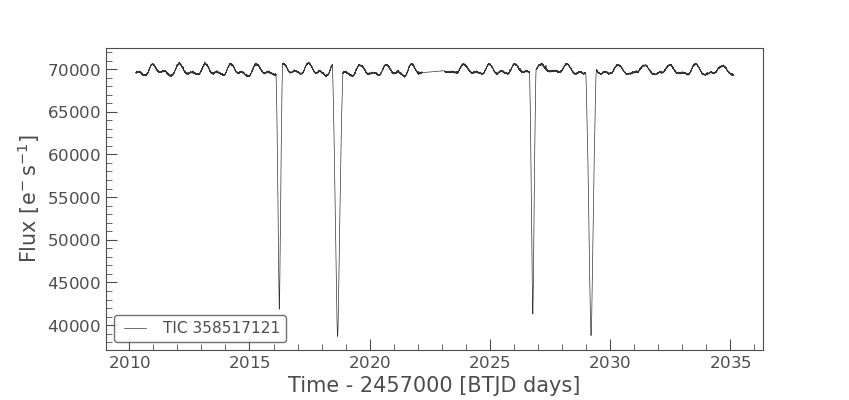

In [3]:
%matplotlib notebook
a = spoc.plot()

<IPython.core.display.Javascript object>


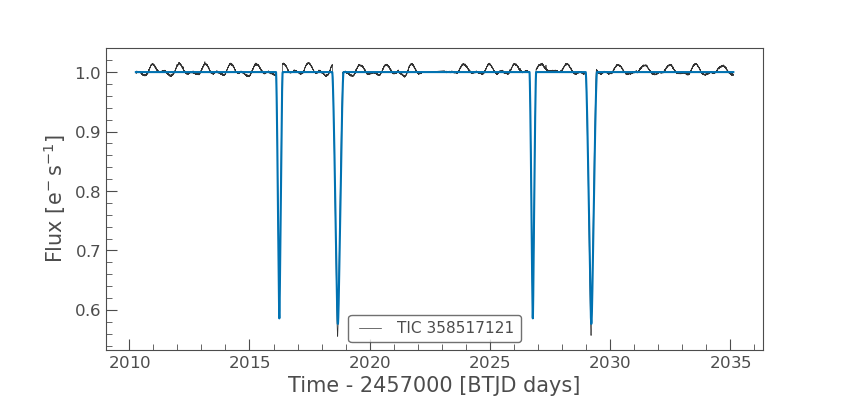

In [4]:
#create spherical star system presented in Gaudi et al. 2017
pri_map1 = starry.Map(udeg=2, gdeg=4, oblate=True, normalized=True) #ydeg = 2*order_approx udeg=2
pri_map1[1] = 0.10582983
pri_map1[2] = 0.15800942

pri_map1.omega=0.225
pri_map1.beta = 0.08
pri_map1.wav=786.5 #TESS center bandpass
pri_map1.tpole=17300
pri_map1.f = 1-2/(0.225**2 + 2)

pri1 = starry.Primary(pri_map1, m=5.1010866, r=2.66545675,prot=1.07)
sec_map1 = starry.Map(udeg=2)

sec_map1[1] = 0.10582983
sec_map1[2] = 0.15800942
sec_map1.amp=0.4261567900304972/0.550557973523685
sec1 = starry.kepler.Secondary(map=sec_map1,
    m=4.4,  # mass in solar masses
    r=2.4639126,  # radius in solar radii
    porb=10.54980498,  # orbital period in days
    inc=88.90036682,
    Omega=90,  # longitude of ascending node in degrees
    ecc=0.50002386,  # eccentricity
    w=327.28591637,  # longitude of pericenter in degrees
    t0=2018.67830937,  # time of transit in days
)
sys1 = starry.System(pri1, sec1)

(spoc/np.median(spoc.flux.value)).plot()
time = spoc.time.value
model_flux = sys1.flux(time).eval()
plt.plot(time, model_flux/np.median(model_flux));

grav_map = pri1.map._f.eval()

In [5]:
#primary limb darkening
u1_m = 0.124
u1_e = 0.1
u2_m = 0.262 
u2_e = 0.1


#primary mass and radius
A_m_m = 5.1
A_m_e = 0.2
A_r_m = 2.4
A_r_e = 0.3

#primary rot period and tpole
A_prot_m =  1.07 #in days
A_omega = 0.225 #dimensionless
A_prot_e = 0.1

A_tpole_m = 17300
A_tpole_e = 800

#secondary luminosity ratio
B_amp_l = 0.6
B_amp_u = 0.8
#secondary mass and radius
B_m_m = 4.4
B_m_e = 0.2
B_r_m = 2.5
B_r_e = 0.3

#secondary tpole
B_tpole_m = 15400
B_tpole_e = 800

#secondary vsini
B_vsini_m = 100
B_vsini_e = 30

#orbital parameters
orb_inc_m = 89.02
orb_inc_e = 1.0


G_mks = 6.67e-11
Msun = 1.989e+30
Rsun = 6.95700e8

In [6]:
import theano.tensor as tt

time = spoc.time.value
flux = spoc.flux.value/np.median(spoc.flux.value)
ferr = spoc.flux_err.value/np.median(spoc.flux.value)

with pm.Model() as model:

    # These are the variables we're solving for;
    # here we're placing wide Gaussian priors on them.
    BoundedNormal = pm.Bound(pm.Normal, lower=0)
    
    A_m = BoundedNormal("A_M",mu=A_m_m,sd=A_m_e,testval=A_m_m)
    A_r = BoundedNormal("A_R",mu=A_r_m,sd=A_r_e,testval=A_r_m)
    A_inc_rad = pmx.Periodic("A inc", lower=0, upper=np.pi/2)
    A_inc = pm.Deterministic("A inc deg", A_inc_rad*180/np.pi)
    A_prot = BoundedNormal("A_prot",mu=1.07,sd=0.1,testval=1.07)
    
    pm.Potential("isotropy", tt.log(tt.sin(A_inc_rad)))
    
    u1 = BoundedNormal("u1",mu=u1_m,sd=u1_e, testval=u1_m+0.001)
    u2 = BoundedNormal("u2",mu=u2_m,sd=u2_e,testval=u2_m-0.001)
    
    
    pri_map = starry.Map(udeg=2,ydeg=4) #ydeg = 2*order_approx udeg=2
    pri_map[1] = u1
    pri_map[2] = u2
    pri_map.inc= A_inc
    
    primary = starry.Primary(pri_map, m=A_m, r=A_r,prot=A_prot)

    #spin orbit parameters
    #pm.Deterministic("inc planet", orbit.incl*180/np.pi)
    #pm.Deterministic("true spin orbit", tt.arccos(tt.cos(orbit.incl)*tt.cos(inc_s)
                                              # + tt.sin(inc_s)*tt.cos(omega_p)*tt.sin(orbit.incl))*180/np.pi)
 
    B_r = BoundedNormal("B_R",mu=B_r_m,sd=B_r_e,testval=B_r_m)
    #omega_p = pmx.Angle("Omega")
    #lambda_p = pm.Deterministic("lambda", omega_p*180/np.pi) #the projected obliquity in degrees

    sec_map = starry.Map(udeg=2,ydeg=1)
    sec_map[1] = u1
    sec_map[2] = u2
    secondary = starry.kepler.Secondary(map=sec_map,
        m=4.4,  # mass in solar masses
        r=B_r,  # radius in solar radii
        porb=BoundedNormal("period",mu=10.55004,sd=0.001, testval=10.55004),  # orbital period in days
        inc=pm.Uniform("inc orb",lower=88.90,upper=89.8, testval=89.02),
        Omega=90,  # longitude of ascending node in degrees, assume pole on
        ecc=pm.Uniform("ecc", lower=0.50, upper=0.51, testval=0.505),  # eccentricity
        w=pm.Uniform("long periastron",lower=320.6,upper=330.6, testval=326.5),  # longitude of pericenter in degrees
        t0=pm.Uniform("t0", lower=2018.4681, upper=2018.8681, testval=2018.6681),  # time of transit in days
    )
    
    system = starry.System(primary, secondary)
    
    # This is how we tell `pymc3` about our observations;
    # we are assuming they are ampally distributed about
    # the true model. This line effectively defines our
    # likelihood function.
    #pm.Normal("obs", flux_model, sd=tt.sqrt(tt.exp(log_sigma_lc)**2), observed=flux)

In [7]:
with model:
    system.set_data(flux, C=ferr**2)

    # Prior on primary
    pri_mu = grav_map
    pri_mu[0] = 1
    pri_L = np.zeros(primary.map.Ny)
    pri_L[0] = 1e-2
    pri_L[1:] = 1e-2
    primary.map.set_prior(mu=pri_mu, L=pri_L)
    
    # Prior on secondary
    sec_mu = np.zeros(secondary.map.Ny)
    sec_mu[0] = 0.9
    sec_L = np.zeros(secondary.map.Ny)
    sec_L[0] = 1e-4
    sec_L[1:] = 1e-4
    secondary.map.set_prior(mu=sec_mu, L=sec_L)


    pm.Potential("marginal", system.lnlike(t=time))

In [8]:
with model:
    map_soln = pmx.optimize()

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x000002207188F400>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x000002207188F400>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
optimizing logp for variables: [t0, long periastron, ecc, inc orb, period, B_R, u2, u1, A_prot, A inc, A_R, A_M]


message: Desired error not necessarily achieved due to precision loss.
logp: -168716.38628561678 -> 19684.183119039455


In [9]:
with model:
    x = pmx.eval_in_model(system.solve(t=time)[0], point=map_soln)
    primary.map.amp = x[0]
    primary.map[1:, :] = x[1 : primary.map.Ny] / primary.map.amp
    secondary.map.amp = x[primary.map.Ny]
    secondary.map[1:, :] = x[primary.map.Ny + 1 :] / secondary.map.amp
    flux_model = pmx.eval_in_model(system.flux(t=time), point=map_soln)

In [10]:
with open('MAPSoln.txt', 'w') as MAPfile:
     MAPfile.write(str(map_soln))
map_soln

{'A_M_lowerbound__': array(1.62944291),
 'A_R_lowerbound__': array(0.98037289),
 'A inc_periodic__': array([ 2.64709232, -3.60451579]),
 'A_prot_lowerbound__': array(0.07237746),
 'u1_lowerbound__': array(-2.24535639),
 'u2_lowerbound__': array(-1.84569244),
 'B_R_lowerbound__': array(0.90174968),
 'period_lowerbound__': array(2.35610737),
 'inc orb_interval__': array(-7.80442223),
 'ecc_interval__': array(-6.03156992),
 'long periastron_interval__': array(0.70180696),
 't0_interval__': array(0.10218496),
 'A_M': array(5.10103218),
 'A_R': array(2.66544997),
 'A inc': array(1.41243868),
 'A inc deg': array(80.92677536),
 'A_prot': array(1.07506106),
 'u1': array(0.1058898),
 'u2': array(0.15791594),
 'B_R': array(2.4639104),
 'period': array(10.54980498),
 'inc orb': array(88.90036698),
 'ecc': array(0.50002396),
 'long periastron': array(327.28588277),
 't0': array(2018.67830961)}

<IPython.core.display.Javascript object>


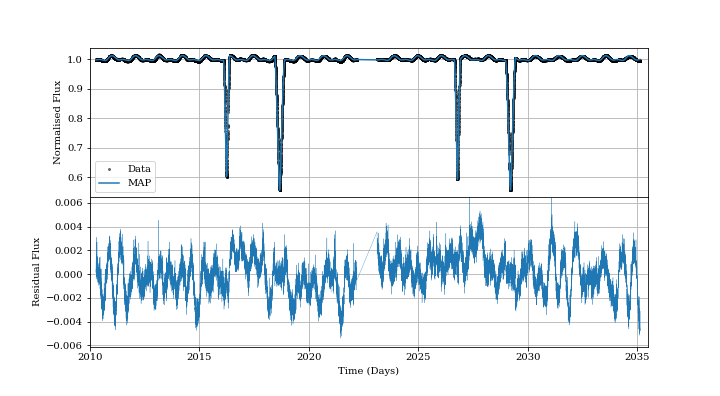

In [11]:
plt.rcParams['font.family'] = 'Serif'
fig, (ax, ax2) = plt.subplots(2, figsize=(10, 5.5), sharex=True)
fig.subplots_adjust(hspace=0)


ax.plot(time, flux, "k.", alpha=0.5, ms=4, label="Data")
ax.plot(time, flux_model, "C0", label="MAP")
ax2.plot(time, flux-flux_model, "C0", label="Residual", lw=0.3)

ax.set_ylabel('Normalised Flux'); ax2.set_ylabel('Residual Flux'); ax2.set_xlabel("Time (Days)")
ax.legend(); ax.grid(); ax2.grid()
ax.set_xlim(2010, 2035.5); ax2.set_ylim(ymax=0.0065)
fig.savefig('Flux Model (ydeg=4, g-dark prior).png', dpi=400, bbox_inches='tight')
fig.savefig('Flux Model (ydeg=4, g-dark prior).pdf', dpi=400, bbox_inches='tight')

2016.2421204866569


<IPython.core.display.Javascript object>


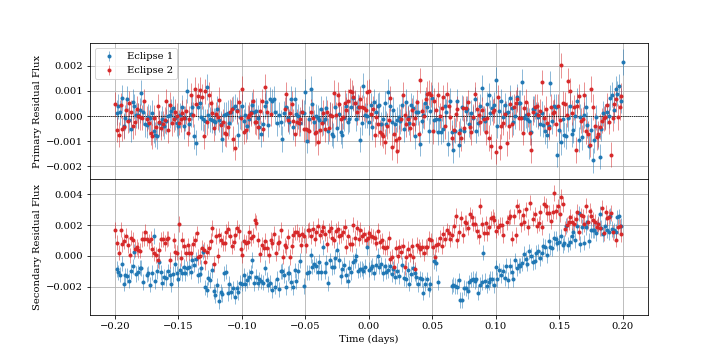

In [18]:
resflux = flux-flux_model
MidPrimary1 = map_soln["t0"]; MidPrimary2 = map_soln["t0"] + map_soln['period']
primary1index = [i for i, t in enumerate(time) if (MidPrimary1 - 0.2) <= t <= (MidPrimary1 + 0.2)]
primary2index = [i for i, t in enumerate(time) if (MidPrimary2 - 0.2) <= t <= (MidPrimary2 + 0.2)]

sec_t0 = 0; sec_t0Flux = 1
for i, t in enumerate(time):
    if 2015 <= t <= 2018:
        if flux[i] < sec_t0Flux:
            sec_t0Flux = flux[i]; sec_t0 = t
MidSecondary1 = sec_t0; MidSecondary2 = sec_t0 + map_soln['period']
secondary1index = [i for i, t in enumerate(time) if (MidSecondary1 - 0.2) <= t <= (MidSecondary1 + 0.2)]
secondary2index = [i for i, t in enumerate(time) if (MidSecondary2 - 0.2) <= t <= (MidSecondary2 + 0.2)]

print(sec_t0)

fig, (ax, ax2) = plt.subplots(2, figsize=(10, 5), sharex=True)
fig.subplots_adjust(hspace=0)
ax.errorbar(time[primary1index] - MidPrimary1, resflux[primary1index], yerr=5e-4, fmt='.', color='tab:blue', label='Eclipse 1', lw=0.5)
ax.errorbar(time[primary2index] - MidPrimary2, resflux[primary2index], yerr=5e-4, fmt='.', color='tab:red', label='Eclipse 2', lw=0.5)

ax2.errorbar(time[secondary1index] - MidSecondary1, resflux[secondary1index], yerr=5e-4, fmt='.', color='tab:blue', lw=0.5)
ax2.errorbar(time[secondary2index] - MidSecondary2, resflux[secondary2index], yerr=5e-4, fmt='.', color='tab:red', lw=0.5)

ax.axhline(0, c='k', lw=0.7, ls=':'); ax.axhline(0, c='k', lw=0.7, ls=':')

ax.set_ylabel("Primary Residual Flux")
ax2.set_xlabel("Time (days)")
ax2.set_ylabel("Secondary Residual Flux")

ax.legend(loc="upper left")
ax.grid(); ax2.grid()
fig.savefig('Residual Eclipse Zoom (ydeg=4, g-dark prior).png', dpi=400, bbox_inches='tight')
fig.savefig('Residual Eclipse Zoom (ydeg=4, g-dark prior).pdf', dpi=400, bbox_inches='tight')


In [13]:
import matplotlib.gridspec as gridspec
from astropy.timeseries import LombScargle

res_flux = flux - flux_model
days = np.linspace(0.01, 30, 10000)
freqs = 1 / days
LS = LombScargle(time, res_flux) # initialize a Lomb-Scargle
power = LS.power(freqs) # calculate LS power 

<IPython.core.display.Javascript object>


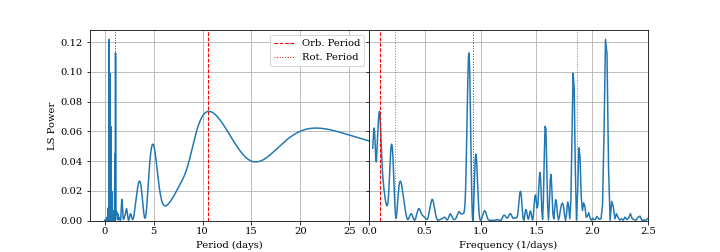

In [14]:
# fig = plt.figure(figsize=(10, 3.5))
# gs = gridspec.GridSpec(1, 2, figure=fig, wspace=0)
# ax1 = fig.add_subplot(gs[0, 0])
# ax2 = fig.add_subplot(gs[0, 1], yticklabels=[])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
fig.subplots_adjust(wspace=0)

ax1.plot(1 / freqs, power)
ax1.set_xlabel('Period (days)')
ax1.set_ylabel('LS Power')
ax1.axvline(map_soln['period'], c='r', ls='--', lw=1, label=f"Orb. Period")# ({map_soln['period']:.2f} days)")
ax1.axvline(map_soln['A_prot'], c='r', ls=':', lw=1, label=f"Rot. Period")# ({map_soln['A_prot']:.2f} days)")
ax1.set_ylim(ymin=0); ax1.set_xlim(xmax=27)
ax1.legend()

ax2.plot(freqs, power)
ax2.set_xlabel('Frequency (1/days)')
ax2.set_xlim(0, 2.5)
ax2.axvline(1 / map_soln['period'], c='r', ls='--', lw=1, label=f"Orb. Period")# ({map_soln['period']:.2f} days)")
ax2.axvline(1 / map_soln['A_prot'], c='r', ls=':', lw=1, label=f"Rot. Period")# ({map_soln['A_prot']:.2f} days)")
ax2.axvline(2 / (map_soln['A_prot']), c='tab:purple', ls=':', lw=1, label=f"Rot. Period")
ax2.axvline(1 / (4 * map_soln['A_prot']), c='tab:purple', ls=':', lw=1, label=f"Rot. Period")

ax1.grid(); ax2.grid()

fig.savefig('Residuals Lomb-Scargle (ydeg=4, g-dark prior).png', dpi=400, bbox_inches='tight')
fig.savefig('Residuals Lomb-Scargle (ydeg=4, g-dark prior).pdf', dpi=400, bbox_inches='tight')

<IPython.core.display.Javascript object>


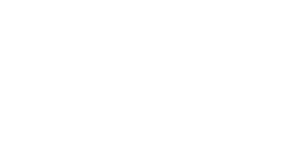

In [15]:
map1 = starry.Map(ydeg=4)
map1.inc = map_soln["A inc deg"]
map1.amp = x[0]
map1[1:, :] = x[1 : primary.map.Ny] / map1.amp
map1.show(theta=np.linspace(0, 360, 50))

<IPython.core.display.Javascript object>


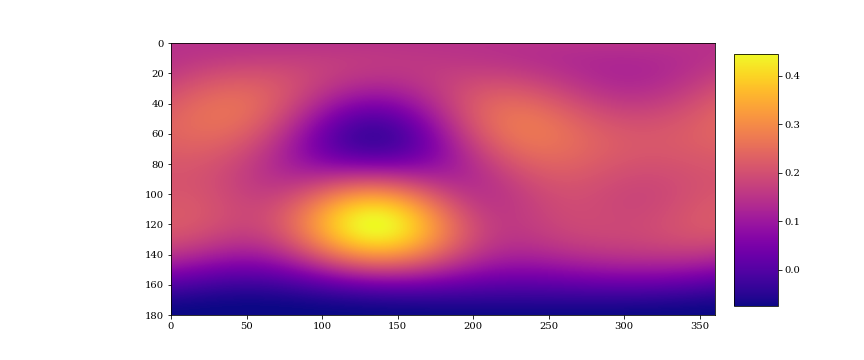

In [16]:
surfMap = map1.render(projection="rect").eval()

fig, ax = plt.subplots(figsize=(12, 5))

img = ax.imshow(surfMap, cmap="plasma", extent=(0, 360, 180, 0))
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])

fig.colorbar(img, cax=cbar_ax)
fig.savefig('Surface Map ydeg=4, gdark prior.png', dpi=400)